# GNR652 FusAtNet(CVPRw 2020) Paper Implementation Project
# Code Authors: Vikrant Rangnekar, Prathmesh Bele, Ruturaj D

In [ ]:
!pip install rasterio
import rasterio

     |████████████████████████████████| 19.3 MB 1.3 MB/s 


Rasterio library is needed to read the .tif files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ds = rasterio.open('/content/drive/My Drive/Colab Notebooks/HyperSpectral/2013_IEEE_GRSS_DF_Contest_CASI.tif')

Scaling the hyper spectral data data to maximum value of 1

In [ ]:
import numpy as np
hysp=np.zeros((144,349,1905))
for i in range(144):
  x=ds.read(i+1)
  m=np.amax(x)
  x=x/m
  hysp[i]=x
print(hysp.shape)


(144, 349, 1905)


In [ ]:
hysp1=np.swapaxes(hysp,2,0)

Data Visualization: Viewing the 50th spectrum data

(1905, 349)


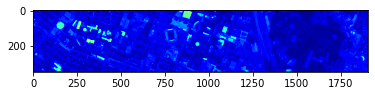

In [ ]:
import matplotlib.pyplot as plt
a=hysp1[:,:,50]
print(a.shape)
# plt.plot(hysp[:,:,1])
plt.imshow(a.T,cmap="jet")
plt.show()

Loading the training data info in a dataframe

In [ ]:
import pandas as pd

df =pd.read_csv("/content/drive/My Drive/Colab Notebooks/HyperSpectral/trainingdata.txt",delimiter="\t")
# print(df)
df.rename(columns={"769":"x","7":"y","1":"category"},inplace=True)
left=pd.DataFrame({"x":"769","y":"7","category":"1"},index =[0])
df = pd.concat([left, df]).reset_index(drop = True)
print(df)

        x    y category
0     769    7        1
1     768    7        1
2     772    7        1
3     771    7        1
4     770    7        1
...   ...  ...      ...
2827  293  172       15
2828  293  173       15
2829  294  173       15
2830  292  173       15
2831  293  174       15

[2832 rows x 3 columns]


In [ ]:
df=df.to_numpy()
print(df)

[['769' '7' '1']
 [768 7 1]
 [772 7 1]
 ...
 [294 173 15]
 [292 173 15]
 [293 174 15]]


In [ ]:
y_label_tr=np.zeros(2832)

for i in range(2832):
  y_label_tr[i]=df[i][2]

Loading the Lidar data and scaling accordingly

In [ ]:
ds2=rasterio.open("/content/drive/My Drive/Colab Notebooks/HyperSpectral/2013_IEEE_GRSS_DF_Contest_LiDAR.tif")
print(ds2.shape)

(349, 1905)


In [ ]:
x=ds2.read(1)
m=np.amax(x)
x=x/m
ll=np.swapaxes(x,0,1)
print(ll.shape)


(1905, 349)


In [ ]:
test_co = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/HyperSpectral/test.txt')
test_co.shape

(12197, 3)

In [ ]:
train_co = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/HyperSpectral/trainingdata.txt')
train_co.shape

(2832, 3)

Generating training patches of size 11*11. x and y represent the centers of the patches. Both hyperspectral and lidar data is extracted for each patch.

In [ ]:
p=11
hs_tr=np.zeros((2832,p,p,144))
ld_tr=np.zeros((2832,p,p))
train_label=np.zeros(2832)
for i in range(2832):
  x=int(train_co[i][0])
  y=int(train_co[i][1])
  train_label[i]=int(train_co[i][2]-1)
  if y>=6 and y<=344 and x>=6 and x<=1898:
      hs_tr[i]=hysp1[ x-6:x+5 , y-6:y+5 ,:]
      ld_tr[i]=ll[ x-6:x+5 , y-6:y+5 ]
  
print(hs_tr.shape)

ld_tr=np.reshape(ld_tr,(2832,11,11,1))
print(ld_tr.shape)


(2832, 11, 11, 144)
(2832, 11, 11, 1)


Generating test patches of size 11*11

In [ ]:
p=11
hs_tt=np.zeros((12197,p,p,144))
ld_tt=np.zeros((12197,p,p))
test_label=np.zeros(12197)
for i in range(12197):
  x=int(test_co[i][0])
  y=int(test_co[i][1])
  test_label[i]=int(test_co[i][2]-1)
  if y>=6 and y<=344 and x>=6 and x<=1898:
      hs_tt[i]=hysp1[ x-6:x+5 , y-6:y+5 ,:]
      ld_tt[i]=ll[ x-6:x+5 , y-6:y+5 ]
  
print(hs_tt.shape)

ld_tt=np.reshape(ld_tt,(12197,11,11,1))
print(ld_tt.shape)
print(test_label.shape)

(12197, 11, 11, 144)
(12197, 11, 11, 1)
(12197,)


# **Model Definition:**

First define all the blocks required to make each module of model. This includes ConvUnit(with and without padding), Residual Block 1 and Residual Block 2. Conv Unit without padding is used only in the  classification module

In [ ]:
def ConvUnit(input,num_fil):
  x=tf.keras.layers.Conv2D(num_fil,(3,3),padding="same",use_bias=True)(input)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.Activation("relu")(x)
  return x

In [ ]:
def ConvUnitNoPad(input,num_fil):
  x=tf.keras.layers.Conv2D(num_fil,(3,3),use_bias=True)(input)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.Activation("relu")(x)
  return x

In [ ]:
def ResiUnit1(input,num_fil):
  x=ConvUnit(input,num_fil)
  y=ConvUnit(x,num_fil)
  y=layers.Add()([y,x])
  y = layers.MaxPool2D((2,2),padding="same")(y)
  return y

In [ ]:
def ResiUnit2(input,num_fil):
  x=ConvUnit(input,num_fil)
  y=ConvUnit(x,num_fil)
  y=layers.Add()([y,x])
  return y



In [ ]:
def HypSpFeatExt(input):
  for i in range(5):
    input=ConvUnit(input,256)
  output=ConvUnit(input,1024)
  return output

In [ ]:
def SpecAttMod(input):
  for i in range(2):
    input=ResiUnit1(input,256)
  input=ConvUnit(input,256)
  input=ConvUnit(input,1024)
  input=tf.keras.layers.MaxPool2D((2,2),padding="same")(input)
  output=tf.keras.layers.GlobalAveragePooling2D()(input)
  return output

In [ ]:
def SpaAttMod(input):
  for i in range(2):
    input=ResiUnit2(input,128)
  input1=ConvUnit(input,256)
  output=ConvUnit(input1,1024)
  return output

In [ ]:
def ModFeatExt(input):
  for i in range(5):
    input=ConvUnit(input,256)
  output=ConvUnit(input,1024)
  return output

In [ ]:
def ModAttMod(input):
  for i in range(2):
    input=ResiUnit2(input,128)
  input1=ConvUnit(input,256)
  output=ConvUnit(input1,1024)
  return output

In [ ]:
def ClassMod(input,K):
  for i in range(4):
    input=ConvUnitNoPad(input,256)
  input1=ConvUnitNoPad(input,1024)
  input2=layers.Conv2D(K,(1),activation='softmax')(input1)
  output=keras.layers.Flatten()(input2)
  return output


In [ ]:
w=11
import gc 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input
from sklearn.metrics import confusion_matrix

Defining the model taking 2 inputs of size 11,11,144(Hyperspectral) and 11,11,1(Lidar) and outputing a vector of size 15 corresponding to the number of classes in the dataset. Model has been plotted using keras for easy visualization.

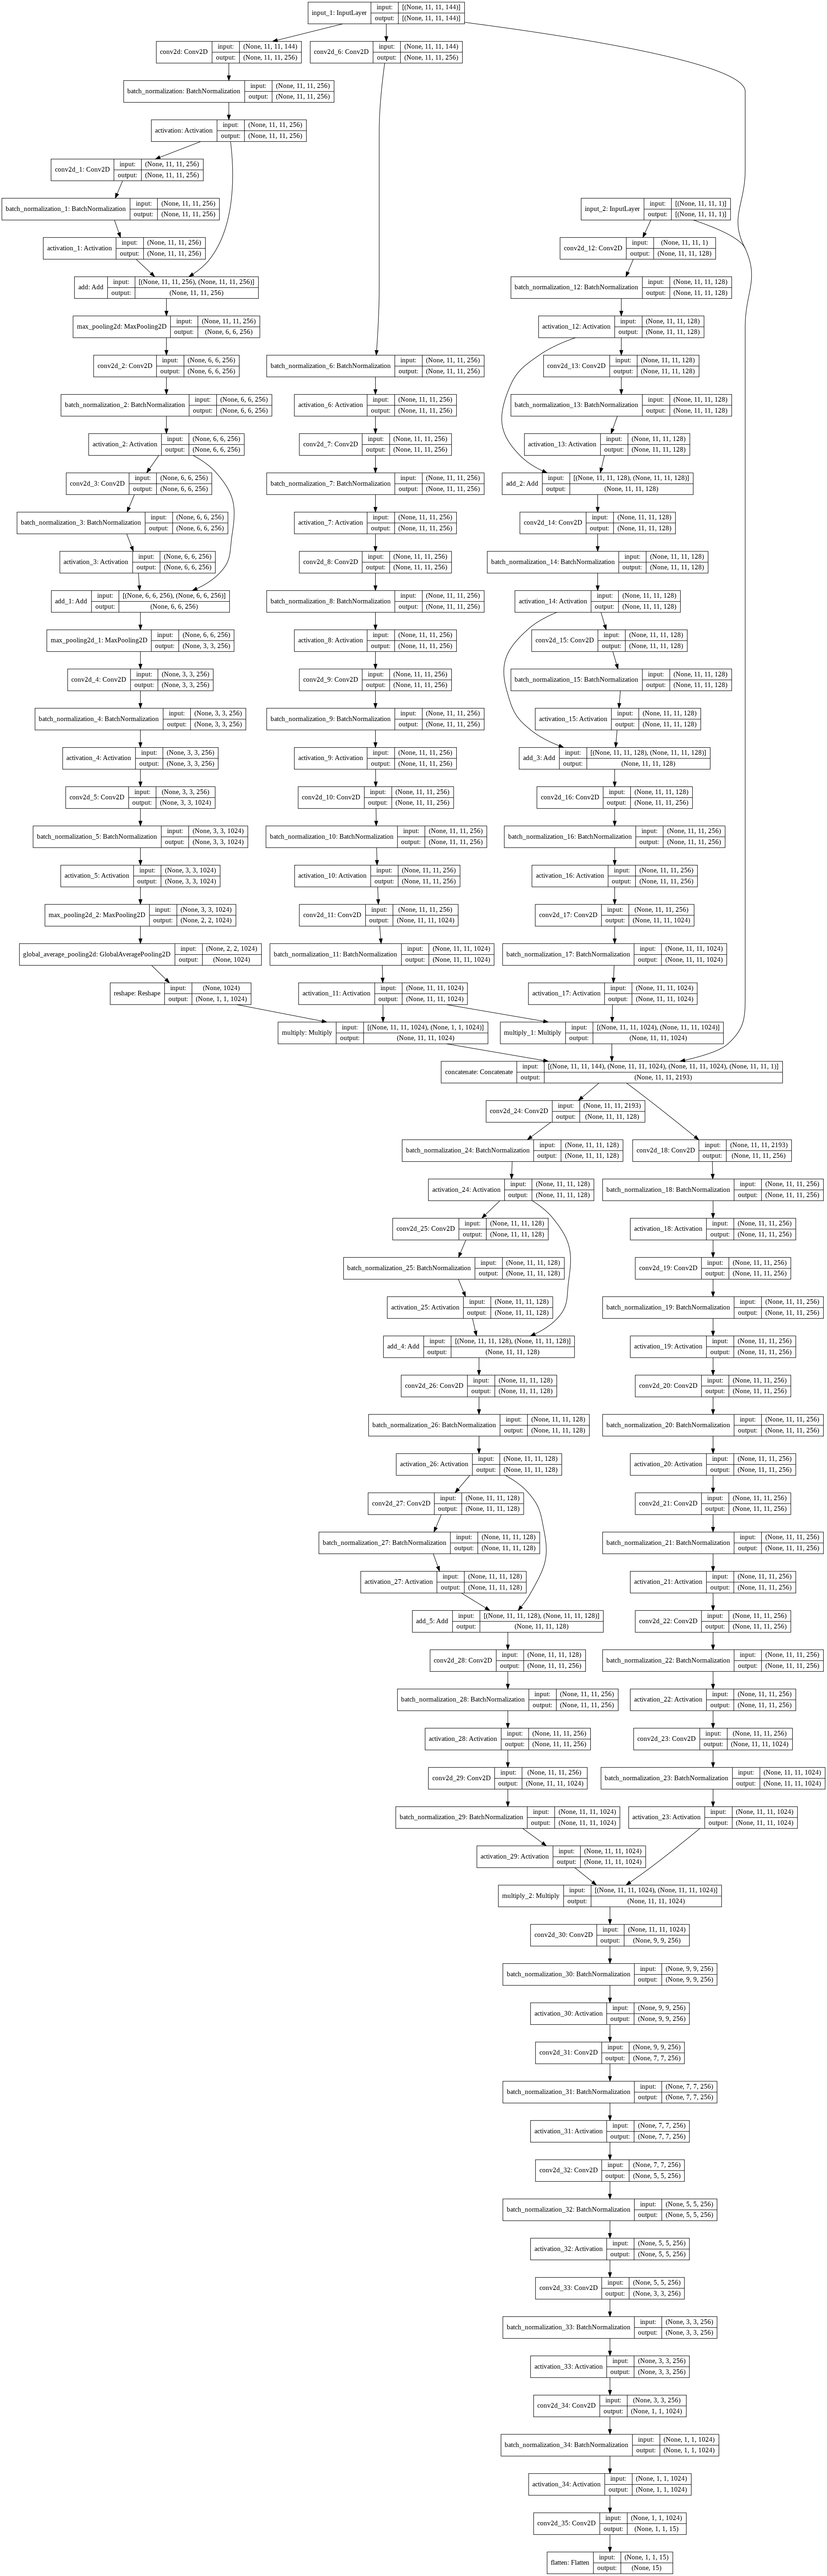

In [ ]:
h = layers.Input(shape=(w,w,144))
l = layers.Input(shape=(w,w,1))


h1,l1 = h,l
AS=SpecAttMod(h1)
AS=layers.Reshape((1,1,-1))(AS)
FHS=HypSpFeatExt(h1)
AT=SpaAttMod(l1)
MS=layers.multiply([FHS,AS])

MT=layers.multiply([FHS,AT])
con=layers.concatenate([h1,MS,MT,l1])
FM=ModFeatExt(con)
AM=ModAttMod(con)
out = layers.multiply([FM,AM])
C=ClassMod(out,15)
model = keras.Model((h,l), (C))
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
epochaccuracy = []
highestaccuracy = [0]
trainacc = []

print(w)

11


Training the model upto 50 epochs and storing the accuracy. Confusion matrix is used for the purpose of calculating accuracy.

In [ ]:
model.compile(keras.optimizers.Adam(5e-6), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
temp_acc = highestaccuracy[-1]
ep = 0
predsf = np.zeros((12917, 11))
for i in range(50):
  gc.collect()
  history = model.fit((hs_tr,ld_tr), (train_label), batch_size=32, epochs=1)
  trainacc.append(history.history["accuracy"])
  preds = model.predict((hs_tt,ld_tt))
  conf = confusion_matrix(test_label, np.argmax(preds,1)) 
  acc = np.trace(conf)/np.sum(conf)
  if acc>temp_acc:
    temp_acc = acc
    ep = i
    predsf = preds
  print('acc_max = ', np.round(100*temp_acc,2), '% at epoch', ep)
  highestaccuracy.append(temp_acc)
  print('epoch_acc = ', round(100*acc,2), '% at epoch', i)
  epochaccuracy.append(acc)

89/89 [==============================] - 62s 288ms/step - loss: 2.7203 - accuracy: 0.1052
acc_max =  3.88 % at epoch 0
epoch_acc =  3.88 % at epoch 0
89/89 [==============================] - 24s 273ms/step - loss: 2.4777 - accuracy: 0.1861
acc_max =  8.49 % at epoch 1
epoch_acc =  8.49 % at epoch 1
89/89 [==============================] - 24s 274ms/step - loss: 2.2842 - accuracy: 0.2948
acc_max =  8.49 % at epoch 1
epoch_acc =  8.49 % at epoch 2
89/89 [==============================] - 25s 275ms/step - loss: 2.1169 - accuracy: 0.3761
acc_max =  8.5 % at epoch 3
epoch_acc =  8.5 % at epoch 3
89/89 [==============================] - 24s 274ms/step - loss: 1.8816 - accuracy: 0.4739
acc_max =  8.5 % at epoch 3
epoch_acc =  7.14 % at epoch 4
89/89 [==============================] - 24s 273ms/step - loss: 1.5855 - accuracy: 0.5932
acc_max =  8.5 % at epoch 3
epoch_acc =  7.67 % at epoch 5
89/89 [==============================] - 24s 273ms/step - loss: 1.3014 - accuracy: 0.6755
acc_max =  11.

Testing accuracy of 80% is obtained. This values is a a bit lesser than the one obtained in the paper since they have trainined for 1000 epochs and also used data augmentation.

Plotting the training and testing accuracy against epoch number.

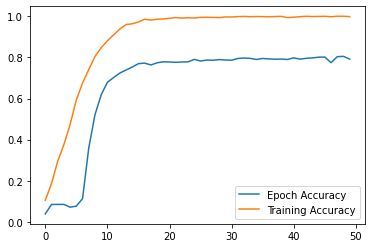

In [ ]:
plt.plot(np.asarray(epochaccuracy),label="Epoch Accuracy")
plt.plot(np.asarray(trainacc), label="Training Accuracy")
plt.legend()

# **Classification map**

Generating a classification map of the entire data. I have color coded each entity with a suitable color to make it look real.

In [ ]:
colorcode = {0: (47, 204, 50),
            1: (1, 255, 1),
            2: (34, 139, 134),
            3: (0, 129, 3),
            4: (158, 84, 45),
            5: (1, 0, 138),
            6: (255, 255, 255),
            7: (255, 255, 1),
            8: (126, 126, 126),
            9: (129, 1, 0),
            10: (255, 20, 148),
            11: (242, 129, 133),
            12: (203, 118, 35),
            13: (255, 0, 249),
            14: (1, 254, 254),
            15: (1,1,139)}


In [ ]:
print(colorcode)

{0: (47, 204, 50), 1: (1, 255, 1), 2: (34, 139, 134), 3: (0, 129, 3), 4: (158, 84, 45), 5: (1, 0, 138), 6: (255, 255, 255), 7: (255, 255, 1), 8: (126, 126, 126), 9: (129, 1, 0), 10: (255, 20, 148), 11: (242, 129, 133), 12: (203, 118, 35), 13: (255, 0, 249), 14: (1, 254, 254), 15: (1, 1, 139)}


To generate the map, we again divide the totoal data in patches of 11*11. Since I have not used any padding here, the size of the map is 1894,338.

In [ ]:
final_class=np.zeros((1894,338))

for j in range(338):
  gc.collect()
  hs=np.zeros((1894,11,11,144))
  lidar=np.zeros((1894,11,11,1))
  for i in range(1894):
    x=i+6
    y=j+6
    hs[i]=hysp1[ x-6:x+5 , y-6:y+5 ,:].reshape((1,11,11,144))
    lidar[i]=ll[ x-6:x+5 , y-6:y+5 ].reshape((1,11,11,1))
  print(j)
  
  class_array=model.predict((hs,lidar))
  for i in range(1894):
    final_class[i][j]=np.argmax(class_array[i])
  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Taking a look at the final classes assigned and saving the numpy file for future reference.

In [ ]:
print(final_class)

[[ 6.  6.  3. ... 11. 11. 12.]
 [ 6.  6.  3. ... 11. 11. 12.]
 [ 6.  6.  3. ... 11. 11. 12.]
 ...
 [ 5.  6.  5. ...  9.  8.  8.]
 [ 5.  6.  5. ...  9.  9.  8.]
 [ 5.  5.  6. ... 10. 10. 10.]]


In [ ]:
np.save("/content/drive/MyDrive/Colab Notebooks/HyperSpectral/HoustonClasses.npy",final_class)

In [ ]:
gc.collect()
import matplotlib.pyplot as plt


In [ ]:
print(np.amax(final_class))

14.0


Plotting the classification map.

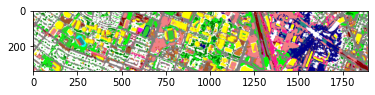

In [ ]:
import matplotlib.pyplot as plt
color_image=np.zeros((1894,338,3))
for i in range(1894):
  for j in range(338):
    color_image[i][j]=colorcode.get(final_class[i][j])
plt.imshow(color_image.swapaxes(1,0)/255)

